[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlnoobs/mlops-project-study/blob/main/2022-05-30/homework/cnrywjd11_mnist_inference.ipynb)

# 딥러닝 remind 세미나 1 - 숙제: mnist inference 해보기
anthony.go

- 훈련된 모델 로드를 위해 아래 taylor의 노트북을 참고했습니다.
  - https://github.com/mlnoobs/mlops-project-study/blob/main/2022-05-30/training_remind_seminar.ipynb
- 훈련부터 인퍼런스 결과 확인까지 할 수 있도록 제작했습니다.

## 필요 툴&라이브러리 설치

In [1]:
!pip install --upgrade pip
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## import

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import torchvision
from matplotlib import pyplot as plt
import time


## Hyperpatemerers 등 configs 세팅

In [3]:
# 훈련 결과 재현을 위한 seed값 고정
seed = '202205281708'
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-2
n_epochs = 10
batch_size = 512

## 공개 데이터셋 다운로드: MNIST
torchvision 라이브러리를 사용하면 공개 데이터셋을 편리하게 다운로드받고, torch tensor 자료형으로 불러올 수 있습니다.

len(train_data): 60000
len(test_data): 10000
shape: torch.Size([1, 28, 28])
label: 3
maxval: tensor(2.8215)
minval: tensor(-0.4242)
mean of all training dataset: tensor(-0.0001)
var of all training dataset: tensor(1.0001)


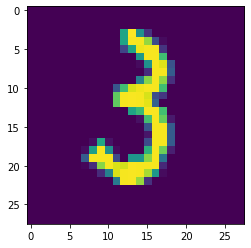

In [27]:
# torchvision 라이브러리를 사용해 MNIST 데이터셋 다운로드 및 전처리
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)) # MNIST 데이터셋의 평균과 표준편차
            ])
train_data = torchvision.datasets.MNIST('./mnist_dataset', train=True, download=True,
                            transform=transform)
test_data = torchvision.datasets.MNIST('./mnist_dataset', train=False, download=True,
                            transform=transform)
print('len(train_data):', len(train_data))
print('len(test_data):', len(test_data))

# 데이터 정보를 확인해봅시다.
sample = train_data[1234]
print('shape:', sample[0].shape)   # 28*28 흑백 데이터
print('label:', sample[1])
print('maxval:', torch.max(sample[0]))
print('minval:', torch.min(sample[0]))
train_data_without_labels = torch.stack([s[0] for s in train_data])
print('mean of all training dataset:', torch.mean(train_data_without_labels))
print('var of all training dataset:', torch.var(train_data_without_labels))
plt.imshow(sample[0][0])
plt.show()

# torch의 DataLoader를 사용하면 데이터셋을 준비하는 과정이 편리합니다.
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
# batchsize 1000->1로 변경하여 test_loader로 조회시 이미지 한장씩 가져옴
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1,
                                          shuffle=True)

## 훈련 & 인퍼런스 테스트 코드 정의

In [28]:
def train_model(model, device, train_loader, optimizer, n_epochs, fn_loss,
                log_interval=10000):
    model.train()
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = fn_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % (log_interval // len(data)) == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(data), len(train_loader.dataset),
                      100. * batch_idx / len(train_loader), loss.item()))
            
def test_model(model, device, data, target):
    model.eval()
    correct = 0
    with torch.no_grad():
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        #디멘젼을 유지 하지 않는다. 1차원으로 변경
        pred = output.argmax(dim=1, keepdim=False)
        print('\n pred: ', pred)
        print('\n target: ', target)
        #그림 그리기 위해선 numpy 타입이 필요해 cpu로 가져옴
        plt.imshow(data[0][0].cpu().numpy())
        plt.show()
        
        #결과값을 보기위해 cpu로 가져와서 numpy 타입으로 변경하고 [0]으로 값을 출력
        print('\n pred[0]: ', pred.cpu().numpy()[0])
        print('\n target[0]: ', target.cpu().numpy()[0])




## Linear layer 3개 학습


In [29]:
class ModelV2(torch.nn.Module):
    def __init__(self):
        super(ModelV2, self).__init__()
        self.input_size = 28*28
        self.hidden_size = 256
        self.output_size = 10
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, self.hidden_size),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.Linear(self.hidden_size, self.output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            x = F.relu(x) if idx != len(self.layers)-1 else x
        output = F.log_softmax(x, dim=1)
        return output

print("loading ModelV2...") 
model = ModelV2().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
fn_loss = F.nll_loss
print("loaded ModelV2 to {}".format(device))
print(model)
print('Number of model parameters: ', sum(param.numel() for param in model.parameters()))
print("device:", device)
print("lr:", lr)
print("n_epochs:", n_epochs)
print("batch_size:", batch_size)


train_model(model, device, train_loader, optimizer, n_epochs, fn_loss, log_interval=60000)

loading ModelV2...
loaded ModelV2 to cuda
ModelV2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
Number of model parameters:  269322
device: cuda
lr: 0.01
n_epochs: 10
batch_size: 512
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312358
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.669297
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.814515
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.607452
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.454868
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.455215
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.390218
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.307778
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.336194
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.275993


## 인퍼런스 테스트


 pred:  tensor([9], device='cuda:0')

 target:  tensor([9], device='cuda:0')


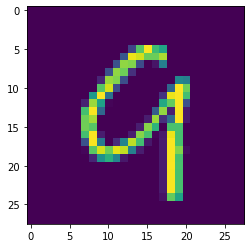


 pred[0]:  9

 target[0]:  9
Eval done. elapsed: 0.11174757000026148 sec


In [26]:
# cnt: batchsize가 1인 상태에서 데이터 하나만 가져오기 위함
cnt = 0
for data, target in test_loader:
    t = time.perf_counter()
    test_model(model, device, data, target)
    print("Eval done. elapsed: {} sec".format(time.perf_counter() - t))
    cnt += 1
    if cnt == 10:
      break

# 모델 재학습 시키지 않기 위해
# del model
# del optimizer
# torch.cuda.empty_cache()